# Baseline B: Multi-Agent Supervisor Research System

This notebook implements a sophisticated multi-agent research system with:
1. **User Clarification** - Interactive scoping to understand research needs
2. **Research Brief Generation** - Structured research question creation
3. **Multi-Agent Supervisor** - Coordinates parallel research agents
4. **Research Agents** - Specialized sub-agents for focused topics
5. **Final Report Synthesis** - Comprehensive report generation

**Technology Stack:**
- LLM: `gpt-5-mini-2025-08-07`
- Web Search: Tavily API
- Tracing: LangSmith
- Framework: LangGraph

## 1. Setup and Configuration

In [27]:
import os
import operator
import asyncio
from pathlib import Path
from datetime import datetime
from typing import List, Annotated, Sequence, Literal

from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    AIMessage, 
    HumanMessage, 
    SystemMessage, 
    BaseMessage,
    ToolMessage,
    get_buffer_string,
    filter_messages
)
from langchain_core.tools import tool, InjectedToolArg
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langgraph.types import Command
from tavily import TavilyClient

from IPython.display import Image, display

# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("nest_asyncio applied for Jupyter compatibility")
except ImportError:
    print("nest_asyncio not available - install with: pip install nest_asyncio")

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Verify API keys
assert os.environ.get("OPENAI_API_KEY"), "OPENAI_API_KEY not set"
assert os.environ.get("TAVILY_API_KEY"), "TAVILY_API_KEY not set"
assert os.environ.get("LANGSMITH_API_KEY"), "LANGSMITH_API_KEY not set"

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

nest_asyncio applied for Jupyter compatibility
Environment configured successfully


In [28]:
# Model Configuration
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
summarization_llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_tokens=4000)
compress_llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_tokens=32000)
writer_llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_tokens=32000)

# Tavily client
tavily_client = TavilyClient()

# System constants
max_researcher_iterations = 6
max_concurrent_researchers = 3

print(f"Using model: {MODEL_NAME}")

Using model: gpt-5-mini-2025-08-07


### 1.5 Prompt Templates

In [29]:
"""Prompt templates for the deep research system.

This module contains all prompt templates used across the research workflow components,
including user clarification, research brief generation, and report synthesis.
"""

clarify_with_user_instructions="""
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.
IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.

If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.
If you need to ask a question, follow these guidelines:
- Be concise while gathering all necessary information
- Make sure to gather all the information needed to carry out the research task in a concise, well-structured manner.
- Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and will be rendered correctly if the string output is passed to a markdown renderer.
- Don't ask for unnecessary information, or information that the user has already provided. If you can see that the user has already provided the information, do not ask for it again.

Respond in valid JSON format with these exact keys:
"need_clarification": boolean,
"question": "<question to ask the user to clarify the report scope>",
"verification": "<verification message that we will start research>"

If you need to ask a clarifying question, return:
"need_clarification": true,
"question": "<your clarifying question>",
"verification": ""

If you do not need to ask a clarifying question, return:
"need_clarification": false,
"question": "",
"verification": "<acknowledgement message that you will now start research based on the provided information>"

For the verification message when no clarification is needed:
- Acknowledge that you have sufficient information to proceed
- Briefly summarize the key aspects of what you understand from their request
- Confirm that you will now begin the research process
- Keep the message concise and professional
"""

transform_messages_into_research_topic_prompt = """You will be given a set of messages that have been exchanged so far between yourself and the user. 
Your job is to translate these messages into a more detailed and concrete research question that will be used to guide the research.

The messages that have been exchanged so far between yourself and the user are:
<Messages>
{messages}
</Messages>

Today's date is {date}.

You will return a single research question that will be used to guide the research.

Guidelines:
1. Maximize Specificity and Detail
- Include all known user preferences and explicitly list key attributes or dimensions to consider.
- It is important that all details from the user are included in the instructions.

2. Handle Unstated Dimensions Carefully
- When research quality requires considering additional dimensions that the user hasn't specified, acknowledge them as open considerations rather than assumed preferences.
- Example: Instead of assuming "budget-friendly options," say "consider all price ranges unless cost constraints are specified."
- Only mention dimensions that are genuinely necessary for comprehensive research in that domain.

3. Avoid Unwarranted Assumptions
- Never invent specific user preferences, constraints, or requirements that weren't stated.
- If the user hasn't provided a particular detail, explicitly note this lack of specification.
- Guide the researcher to treat unspecified aspects as flexible rather than making assumptions.

4. Distinguish Between Research Scope and User Preferences
- Research scope: What topics/dimensions should be investigated (can be broader than user's explicit mentions)
- User preferences: Specific constraints, requirements, or preferences (must only include what user stated)
- Example: "Research coffee quality factors (including bean sourcing, roasting methods, brewing techniques) for San Francisco coffee shops, with primary focus on taste as specified by the user."

5. Use the First Person
- Phrase the request from the perspective of the user.

6. Sources
- If specific sources should be prioritized, specify them in the research question.
- For product and travel research, prefer linking directly to official or primary websites (e.g., official brand sites, manufacturer pages, or reputable e-commerce platforms like Amazon for user reviews) rather than aggregator sites or SEO-heavy blogs.
- For academic or scientific queries, prefer linking directly to the original paper or official journal publication rather than survey papers or secondary summaries.
- For people, try linking directly to their LinkedIn profile, or their personal website if they have one.
- If the query is in a specific language, prioritize sources published in that language.
"""

research_agent_prompt =  """You are a research assistant conducting research on the user's input topic. For context, today's date is {date}.

<Task>
Your job is to use tools to gather information about the user's input topic.
You can use any of the tools provided to you to find resources that can help answer the research question. You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.
</Task>

<Available Tools>
You have access to two main tools:
1. **tavily_search**: For conducting web searches to gather information
2. **think_tool**: For reflection and strategic planning during research

**CRITICAL: Use think_tool after each search to reflect on results and plan next steps**
</Available Tools>

<Instructions>
Think like a human researcher with limited time. Follow these steps:

1. **Read the question carefully** - What specific information does the user need?
2. **Start with broader searches** - Use broad, comprehensive queries first
3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?
4. **Execute narrower searches as you gather information** - Fill in the gaps
5. **Stop when you can answer confidently** - Don't keep searching for perfection
</Instructions>

<Hard Limits>
**Tool Call Budgets** (Prevent excessive searching):
- **Simple queries**: Use 2-3 search tool calls maximum
- **Complex queries**: Use up to 5 search tool calls maximum
- **Always stop**: After 5 search tool calls if you cannot find the right sources

**Stop Immediately When**:
- You can answer the user's question comprehensively
- You have 3+ relevant examples/sources for the question
- Your last 2 searches returned similar information
</Hard Limits>

<Show Your Thinking>
After each search tool call, use think_tool to analyze the results:
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?
</Show Your Thinking>
"""

summarize_webpage_prompt = """You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to create a summary that preserves the most important information from the original web page. This summary will be used by a downstream research agent, so it's crucial to maintain the key details without losing essential information.

Here is the raw content of the webpage:

<webpage_content>
{webpage_content}
</webpage_content>

Please follow these guidelines to create your summary:

1. Identify and preserve the main topic or purpose of the webpage.
2. Retain key facts, statistics, and data points that are central to the content's message.
3. Keep important quotes from credible sources or experts.
4. Maintain the chronological order of events if the content is time-sensitive or historical.
5. Preserve any lists or step-by-step instructions if present.
6. Include relevant dates, names, and locations that are crucial to understanding the content.
7. Summarize lengthy explanations while keeping the core message intact.

When handling different types of content:

- For news articles: Focus on the who, what, when, where, why, and how.
- For scientific content: Preserve methodology, results, and conclusions.
- For opinion pieces: Maintain the main arguments and supporting points.
- For product pages: Keep key features, specifications, and unique selling points.

Your summary should be significantly shorter than the original content but comprehensive enough to stand alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is already concise.

Present your summary in the following format:

```
{{
   "summary": "Your summary here, structured with appropriate paragraphs or bullet points as needed",
   "key_excerpts": "First important quote or excerpt, Second important quote or excerpt, Third important quote or excerpt, ...Add more excerpts as needed, up to a maximum of 5"
}}
```

Here are two examples of good summaries:

Example 1 (for a news article):
```json
{{
   "summary": "On July 15, 2023, NASA successfully launched the Artemis II mission from Kennedy Space Center. This marks the first crewed mission to the Moon since Apollo 17 in 1972. The four-person crew, led by Commander Jane Smith, will orbit the Moon for 10 days before returning to Earth. This mission is a crucial step in NASA's plans to establish a permanent human presence on the Moon by 2030.",
   "key_excerpts": "Artemis II represents a new era in space exploration, said NASA Administrator John Doe. The mission will test critical systems for future long-duration stays on the Moon, explained Lead Engineer Sarah Johnson. We're not just going back to the Moon, we're going forward to the Moon, Commander Jane Smith stated during the pre-launch press conference."
}}
```

Example 2 (for a scientific article):
```json
{{
   "summary": "A new study published in Nature Climate Change reveals that global sea levels are rising faster than previously thought. Researchers analyzed satellite data from 1993 to 2022 and found that the rate of sea-level rise has accelerated by 0.08 mm/year² over the past three decades. This acceleration is primarily attributed to melting ice sheets in Greenland and Antarctica. The study projects that if current trends continue, global sea levels could rise by up to 2 meters by 2100, posing significant risks to coastal communities worldwide.",
   "key_excerpts": "Our findings indicate a clear acceleration in sea-level rise, which has significant implications for coastal planning and adaptation strategies, lead author Dr. Emily Brown stated. The rate of ice sheet melt in Greenland and Antarctica has tripled since the 1990s, the study reports. Without immediate and substantial reductions in greenhouse gas emissions, we are looking at potentially catastrophic sea-level rise by the end of this century, warned co-author Professor Michael Green."  
}}
```

Remember, your goal is to create a summary that can be easily understood and utilized by a downstream research agent while preserving the most critical information from the original webpage.

Today's date is {date}.
"""

# Research agent prompt for MCP (Model Context Protocol) file access
research_agent_prompt_with_mcp = """You are a research assistant conducting research on the user's input topic using local files. For context, today's date is {date}.

<Task>
Your job is to use file system tools to gather information from local research files.
You can use any of the tools provided to you to find and read files that help answer the research question. You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.
</Task>

<Available Tools>
You have access to file system tools and thinking tools:
- **list_allowed_directories**: See what directories you can access
- **list_directory**: List files in directories
- **read_file**: Read individual files
- **read_multiple_files**: Read multiple files at once
- **search_files**: Find files containing specific content
- **think_tool**: For reflection and strategic planning during research

**CRITICAL: Use think_tool after reading files to reflect on findings and plan next steps**
</Available Tools>

<Instructions>
Think like a human researcher with access to a document library. Follow these steps:

1. **Read the question carefully** - What specific information does the user need?
2. **Explore available files** - Use list_allowed_directories and list_directory to understand what's available
3. **Identify relevant files** - Use search_files if needed to find documents matching the topic
4. **Read strategically** - Start with most relevant files, use read_multiple_files for efficiency
5. **After reading, pause and assess** - Do I have enough to answer? What's still missing?
6. **Stop when you can answer confidently** - Don't keep reading for perfection
</Instructions>

<Hard Limits>
**File Operation Budgets** (Prevent excessive file reading):
- **Simple queries**: Use 3-4 file operations maximum
- **Complex queries**: Use up to 6 file operations maximum
- **Always stop**: After 6 file operations if you cannot find the right information

**Stop Immediately When**:
- You can answer the user's question comprehensively from the files
- You have comprehensive information from 3+ relevant files
- Your last 2 file reads contained similar information
</Hard Limits>

<Show Your Thinking>
After reading files, use think_tool to analyze what you found:
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I read more files or provide my answer?
- Always cite which files you used for your information
</Show Your Thinking>"""

lead_researcher_prompt = """You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For context, today's date is {date}.

<Task>
Your focus is to call the "ConductResearch" tool to conduct research against the overall research question passed in by the user. 
When you are completely satisfied with the research findings returned from the tool calls, then you should call the "ResearchComplete" tool to indicate that you are done with your research.
</Task>

<Available Tools>
You have access to three main tools:
1. **ConductResearch**: Delegate research tasks to specialized sub-agents
2. **ResearchComplete**: Indicate that research is complete
3. **think_tool**: For reflection and strategic planning during research

**CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each ConductResearch to assess progress**
**PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously, make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is more efficient than sequential research for comparative or multi-faceted questions. Use at most {max_concurrent_research_units} parallel agents per iteration.
</Available Tools>

<Instructions>
Think like a research manager with limited time and resources. Follow these steps:

1. **Read the question carefully** - What specific information does the user need?
2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the research. Are there multiple independent directions that can be explored simultaneously?
3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still missing?
</Instructions>

<Hard Limits>
**Task Delegation Budgets** (Prevent excessive delegation):
- **Bias towards single agent** - Use single agent for simplicity unless the user request has clear opportunity for parallelization
- **Stop when you can answer confidently** - Don't keep delegating research for perfection
- **Limit tool calls** - Always stop after {max_researcher_iterations} tool calls to think_tool and ConductResearch if you cannot find the right sources
</Hard Limits>

<Show Your Thinking>
Before you call ConductResearch tool call, use think_tool to plan your approach:
- Can the task be broken down into smaller sub-tasks?

After each ConductResearch tool call, use think_tool to analyze the results:
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I delegate more research or call ResearchComplete?
</Show Your Thinking>

<Scaling Rules>
**Simple fact-finding, lists, and rankings** can use a single sub-agent:
- *Example*: List the top 10 coffee shops in San Francisco → Use 1 sub-agent

**Comparisons presented in the user request** can use a sub-agent for each element of the comparison:
- *Example*: Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety → Use 3 sub-agents
- Delegate clear, distinct, non-overlapping subtopics

**Important Reminders:**
- Each ConductResearch call spawns a dedicated research agent for that specific topic
- A separate agent will write the final report - you just need to gather information
- When calling ConductResearch, provide complete standalone instructions - sub-agents can't see other agents' work
- Do NOT use acronyms or abbreviations in your research questions, be very clear and specific
</Scaling Rules>"""

compress_research_system_prompt = """You are a research assistant that has conducted research on a topic by calling several tools and web searches. Your job is now to clean up the findings, but preserve all of the relevant statements and information that the researcher has gathered. For context, today's date is {date}.

<Task>
You need to clean up information gathered from tool calls and web searches in the existing messages.
All relevant information should be repeated and rewritten verbatim, but in a cleaner format.
The purpose of this step is just to remove any obviously irrelevant or duplicate information.
For example, if three sources all say "X", you could say "These three sources all stated X".
Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that you don't lose any information from the raw messages.
</Task>

<Tool Call Filtering>
**IMPORTANT**: When processing the research messages, focus only on substantive research content:
- **Include**: All tavily_search results and findings from web searches
- **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and should not be included in the final research report
- **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process

The think_tool calls contain strategic reflections and decision-making notes that are internal to the research process but do not contain factual information that should be preserved in the final report.
</Tool Call Filtering>

<Guidelines>
1. Your output findings should be fully comprehensive and include ALL of the information and sources that the researcher has gathered from tool calls and web searches. It is expected that you repeat key information verbatim.
2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.
3. In your report, you should return inline citations for each source that the researcher found.
4. You should include a "Sources" section at the end of the report that lists all of the sources the researcher found with corresponding citations, cited against statements in the report.
5. Make sure to include ALL of the sources that the researcher gathered in the report, and how they were used to answer the question!
6. It's really important not to lose any sources. A later LLM will be used to merge this report with others, so having all of the sources is critical.
</Guidelines>

<Output Format>
The report should be structured like this:
**List of Queries and Tool Calls Made**
**Fully Comprehensive Findings**
**List of All Relevant Sources (with citations in the report)**
</Output Format>

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
</Citation Rules>

Critical Reminder: It is extremely important that any information that is even remotely relevant to the user's research topic is preserved verbatim (e.g. don't rewrite it, don't summarize it, don't paraphrase it).
"""

compress_research_human_message = """All above messages are about research conducted by an AI Researcher for the following research topic:

RESEARCH TOPIC: {research_topic}

Your task is to clean up these research findings while preserving ALL information that is relevant to answering this specific research question. 

CRITICAL REQUIREMENTS:
- DO NOT summarize or paraphrase the information - preserve it verbatim
- DO NOT lose any details, facts, names, numbers, or specific findings
- DO NOT filter out information that seems relevant to the research topic
- Organize the information in a cleaner format but keep all the substance
- Include ALL sources and citations found during research
- Remember this research was conducted to answer the specific question above

The cleaned findings will be used for final report generation, so comprehensiveness is critical."""

final_report_generation_prompt = """Based on all the research conducted, create a comprehensive, well-structured answer to the overall research brief:
<Research Brief>
{research_brief}
</Research Brief>

CRITICAL: Make sure the answer is written in the same language as the human messages!
For example, if the user's messages are in English, then MAKE SURE you write your response in English. If the user's messages are in Chinese, then MAKE SURE you write your entire response in Chinese.
This is critical. The user will only understand the answer if it is written in the same language as their input message.

Today's date is {date}.

Here are the findings from the research that you conducted:
<Findings>
{findings}
</Findings>

Please create a detailed answer to the overall research brief that:
1. Is well-organized with proper headings (# for title, ## for sections, ### for subsections)
2. Includes specific facts and insights from the research
3. References relevant sources using [Title](URL) format
4. Provides a balanced, thorough analysis. Be as comprehensive as possible, and include all information that is relevant to the overall research question. People are using you for deep research and will expect detailed, comprehensive answers.
5. Includes a "Sources" section at the end with all referenced links

You can structure your report in a number of different ways. Here are some examples:

To answer a question that asks you to compare two things, you might structure your report like this:
1/ intro
2/ overview of topic A
3/ overview of topic B
4/ comparison between A and B
5/ conclusion

To answer a question that asks you to return a list of things, you might only need a single section which is the entire list.
1/ list of things or table of things
Or, you could choose to make each item in the list a separate section in the report. When asked for lists, you don't need an introduction or conclusion.
1/ item 1
2/ item 2
3/ item 3

To answer a question that asks you to summarize a topic, give a report, or give an overview, you might structure your report like this:
1/ overview of topic
2/ concept 1
3/ concept 2
4/ concept 3
5/ conclusion

If you think you can answer the question with a single section, you can do that too!
1/ answer

REMEMBER: Section is a VERY fluid and loose concept. You can structure your report however you think is best, including in ways that are not listed above!
Make sure that your sections are cohesive, and make sense for the reader.

For each section of the report, do the following:
- Use simple, clear language
- Use ## for section title (Markdown format) for each section of the report
- Do NOT ever refer to yourself as the writer of the report. This should be a professional report without any self-referential language. 
- Do not say what you are doing in the report. Just write the report without any commentary from yourself.
- Each section should be as long as necessary to deeply answer the question with the information you have gathered. It is expected that sections will be fairly long and verbose. You are writing a deep research report, and users will expect a thorough answer.
- Use bullet points to list out information when appropriate, but by default, write in paragraph form.

REMEMBER:
The brief and research may be in English, but you need to translate this information to the right language when writing the final answer.
Make sure the final answer report is in the SAME language as the human messages in the message history.

Format the report in clear markdown with proper structure and include source references where appropriate.

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Each source should be a separate line item in a list, so that in markdown it is rendered as a list.
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
- Citations are extremely important. Make sure to include these, and pay a lot of attention to getting these right. Users will often use these citations to look into more information.
</Citation Rules>
"""

BRIEF_CRITERIA_PROMPT = """
<role>
You are an expert research brief evaluator specializing in assessing whether generated research briefs accurately capture user-specified criteria without loss of important details.
</role>

<task>
Determine if the research brief adequately captures the specific success criterion provided. Return a binary assessment with detailed reasoning.
</task>

<evaluation_context>
Research briefs are critical for guiding downstream research agents. Missing or inadequately captured criteria can lead to incomplete research that fails to address user needs. Accurate evaluation ensures research quality and user satisfaction.
</evaluation_context>

<criterion_to_evaluate>
{criterion}
</criterion_to_evaluate>

<research_brief>
{research_brief}
</research_brief>

<evaluation_guidelines>
CAPTURED (criterion is adequately represented) if:
- The research brief explicitly mentions or directly addresses the criterion
- The brief contains equivalent language or concepts that clearly cover the criterion
- The criterion's intent is preserved even if worded differently
- All key aspects of the criterion are represented in the brief

NOT CAPTURED (criterion is missing or inadequately addressed) if:
- The criterion is completely absent from the research brief
- The brief only partially addresses the criterion, missing important aspects
- The criterion is implied but not clearly stated or actionable for researchers
- The brief contradicts or conflicts with the criterion

<evaluation_examples>
Example 1 - CAPTURED:
Criterion: "Current age is 25"
Brief: "...investment advice for a 25-year-old investor..."
Judgment: CAPTURED - age is explicitly mentioned

Example 2 - NOT CAPTURED:
Criterion: "Monthly rent below 7k"
Brief: "...find apartments in Manhattan with good amenities..."
Judgment: NOT CAPTURED - budget constraint is completely missing

Example 3 - CAPTURED:
Criterion: "High risk tolerance"
Brief: "...willing to accept significant market volatility for higher returns..."
Judgment: CAPTURED - equivalent concept expressed differently

Example 4 - NOT CAPTURED:
Criterion: "Doorman building required"
Brief: "...find apartments with modern amenities..."
Judgment: NOT CAPTURED - specific doorman requirement not mentioned
</evaluation_examples>
</evaluation_guidelines>

<output_instructions>
1. Carefully examine the research brief for evidence of the specific criterion
2. Look for both explicit mentions and equivalent concepts
3. Provide specific quotes or references from the brief as evidence
4. Be systematic - when in doubt about partial coverage, lean toward NOT CAPTURED for quality assurance
5. Focus on whether a researcher could act on this criterion based on the brief alone
</output_instructions>"""

BRIEF_HALLUCINATION_PROMPT = """
## Brief Hallucination Evaluator

<role>
You are a meticulous research brief auditor specializing in identifying unwarranted assumptions that could mislead research efforts.
</role>

<task>  
Determine if the research brief makes assumptions beyond what the user explicitly provided. Return a binary pass/fail judgment.
</task>

<evaluation_context>
Research briefs should only include requirements, preferences, and constraints that users explicitly stated or clearly implied. Adding assumptions can lead to research that misses the user's actual needs.
</evaluation_context>

<research_brief>
{research_brief}
</research_brief>

<success_criteria>
{success_criteria}
</success_criteria>

<evaluation_guidelines>
PASS (no unwarranted assumptions) if:
- Brief only includes explicitly stated user requirements
- Any inferences are clearly marked as such or logically necessary
- Source suggestions are general recommendations, not specific assumptions
- Brief stays within the scope of what the user actually requested

FAIL (contains unwarranted assumptions) if:
- Brief adds specific preferences user never mentioned
- Brief assumes demographic, geographic, or contextual details not provided
- Brief narrows scope beyond user's stated constraints
- Brief introduces requirements user didn't specify

<evaluation_examples>
Example 1 - PASS:
User criteria: ["Looking for coffee shops", "In San Francisco"] 
Brief: "...research coffee shops in San Francisco area..."
Judgment: PASS - stays within stated scope

Example 2 - FAIL:
User criteria: ["Looking for coffee shops", "In San Francisco"]
Brief: "...research trendy coffee shops for young professionals in San Francisco..."
Judgment: FAIL - assumes "trendy" and "young professionals" demographics

Example 3 - PASS:
User criteria: ["Budget under $3000", "2 bedroom apartment"]
Brief: "...find 2-bedroom apartments within $3000 budget, consulting rental sites and local listings..."
Judgment: PASS - source suggestions are appropriate, no preference assumptions

Example 4 - FAIL:
User criteria: ["Budget under $3000", "2 bedroom apartment"] 
Brief: "...find modern 2-bedroom apartments under $3000 in safe neighborhoods with good schools..."
Judgment: FAIL - assumes "modern", "safe", and "good schools" preferences
</evaluation_examples>
</evaluation_guidelines>

<output_instructions>
Carefully scan the brief for any details not explicitly provided by the user. Be strict - when in doubt about whether something was user-specified, lean toward FAIL.
</output_instructions>"""

## 2. Utility Functions

In [30]:
def get_today_str() -> str:
    """Get current date in human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """

    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.

    Args:
        webpage_content: Raw webpage content to summarize

    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_llm.with_structured_output(Summary)

        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])

        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )

        return formatted_summary

    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.

    Args:
        search_results: List of search result dictionaries

    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}
    for response in search_results:
        for result in response.get('results', []):
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.

    Args:
        unique_results: Dictionary of unique search results

    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}
    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])
        
        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.

    Args:
        summarized_results: Dictionary of processed search results

    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

## 3. Research Tools

In [31]:
@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

## 4. State Definitions

In [32]:
# ===== SCOPING STATE DEFINITIONS =====

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.

    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """

    # Research brief generated from user conversation history
    research_brief: Optional[str]
    # Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed and structured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    # Final formatted research report
    final_report: str

# ===== RESEARCH AGENT STATE DEFINITIONS =====

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.

    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.

    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== SUPERVISOR STATE DEFINITIONS =====

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.

    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """

    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], operator.add] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""

    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""

    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

## 5. Research Scoping Workflow

In [33]:
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed with research.

    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    # Set up structured output model
    structured_output_model = llm.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])

    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive research brief.

    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = llm.with_structured_output(ResearchQuestion)

    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])

    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

## 6. Research Agent Implementation

In [34]:
# ===== RESEARCH AGENT IMPLEMENTATION =====

# Set up tools and model binding
research_tools = [tavily_search, think_tool]
research_model_with_tools = llm.bind_tools(research_tools)
tools_by_name = {tool.name: tool for tool in research_tools}

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.

    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information

    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            research_model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt.format(date=get_today_str()))] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.

    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls

    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))

    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]

    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.

    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """

    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message.format(research_topic=state.get("research_topic", "")))]
    response = compress_llm.invoke(messages)

    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.

    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.

    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
research_agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
research_agent_builder.add_node("llm_call", llm_call)
research_agent_builder.add_node("tool_node", tool_node)
research_agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
research_agent_builder.add_edge(START, "llm_call")
research_agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
research_agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
research_agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = research_agent_builder.compile()
print("Research agent compiled successfully")

Research agent compiled successfully


## 7. Multi-Agent Supervisor

In [35]:
# ===== MULTI-AGENT SUPERVISOR =====

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.

    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.

    Args:
        messages: List of messages from supervisor's conversation history

    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# Supervisor tools and model configuration
supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model_with_tools = llm.bind_tools(supervisor_tools)

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.

    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete

    Args:
        state: Current supervisor state with messages and research progress

    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])

    # Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages

    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)

    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.

    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete

    Args:
        state: Current supervisor state with messages and iteration count

    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]

    # Initialize variables for single return pattern
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # Default next step
    should_end = False

    # Check exit criteria first
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )

    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END

    else:
        # Execute ALL tool calls before deciding next step
        try:
            # Separate think_tool calls from ConductResearch calls
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]

            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # Handle think_tool calls (synchronous)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            # Handle ConductResearch calls (asynchronous)
            if conduct_research_calls:
                # Launch parallel research agents
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # Wait for all research to complete
                tool_results = await asyncio.gather(*coros)

                # Format research results as tool messages
                # Each sub-agent returns compressed research findings in result["compressed_research"]
                # We write this compressed research as the content of a ToolMessage, which allows
                # the supervisor to later retrieve these findings via get_notes_from_tool_calls()
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]

                tool_messages.extend(research_tool_messages)

                # Aggregate raw notes from all research
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]

        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END

    # Single return point with appropriate state updates
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ===== GRAPH CONSTRUCTION =====

# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()
print("Supervisor agent compiled successfully")

Supervisor agent compiled successfully


c:\Users\Gajanan Vigneswaran\OneDrive - Ryerson University\Desktop\Deep-Research-Agent\venv\Lib\site-packages\IPython\core\inputtransformer2.py:538: RuntimeWarning: coroutine 'Pregel.ainvoke' was never awaited
  tokens_by_line.append([])


## 8. Final Report Generation

In [36]:
async def final_report_generation(state: AgentState):
    """
    Final report generation node.

    Synthesizes all research findings into a comprehensive final report
    """
    notes = state.get("notes", [])
    findings = "\n\n".join(notes)
    
    prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_llm.ainvoke([HumanMessage(content=prompt)])
    
    return {
        "final_report": final_report.content,
        "messages": ["Here is the final report: " + final_report.content],
    }

## 9. Complete System Assembly

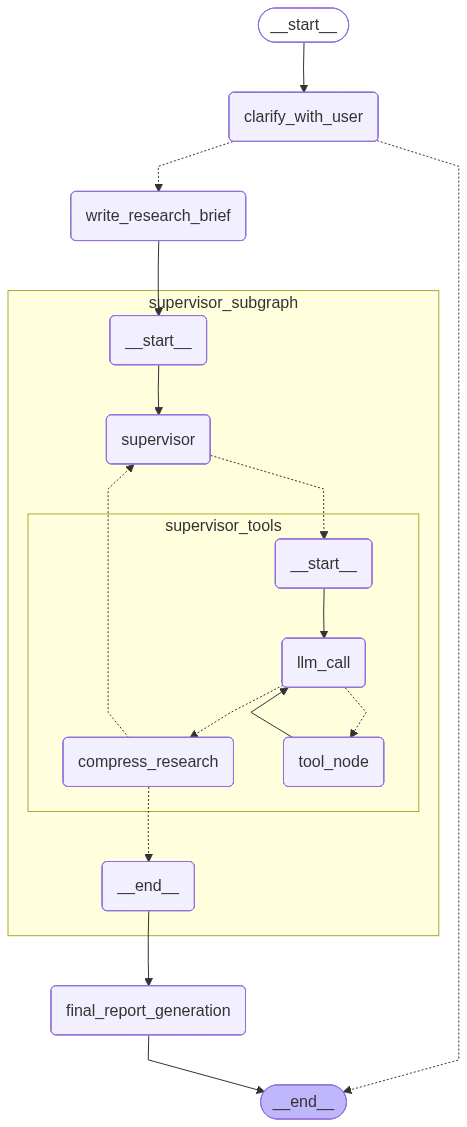

Complete research system compiled successfully


In [37]:
# Build complete research system
full_system_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add all nodes
full_system_builder.add_node("clarify_with_user", clarify_with_user)
full_system_builder.add_node("write_research_brief", write_research_brief)
full_system_builder.add_node("supervisor_subgraph", supervisor_agent)
full_system_builder.add_node("final_report_generation", final_report_generation)

# Add edges
full_system_builder.add_edge(START, "clarify_with_user")
full_system_builder.add_edge("write_research_brief", "supervisor_subgraph")
full_system_builder.add_edge("supervisor_subgraph", "final_report_generation")
full_system_builder.add_edge("final_report_generation", END)

# Compile with high recursion limit
research_graph = full_system_builder.compile()

# Visualize
display(Image(research_graph.get_graph(xray=True).draw_mermaid_png()))
print("Complete research system compiled successfully")

## 10. Agent Wrapper for Evaluation

In [38]:
def baseline_b_agent(inputs: dict) -> dict:
    """
    Wrapper function for multi-agent supervisor research system.
    
    Compatible with evaluation harness.
    
    Args:
        inputs: Dictionary with 'question' key
        
    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")
    
    # Run with high recursion limit
    result = asyncio.run(
        research_graph.ainvoke(
            {"messages": [HumanMessage(content=question)]},
            config={"recursion_limit": 50}
        )
    )
    
    return {
        "output": result.get("final_report", ""),
        "research_brief": result.get("research_brief", ""),
        "notes": result.get("notes", [])
    }

## 11. Manual Test (Before Harness Evaluation)

Run this cell to verify the agent works correctly with a simple test question.

In [ ]:
# Simple test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing with question: {test_question}\n")
print("Running multi-agent research system (this may take several minutes)...\n")
print("NOTE: System will use supervisor to coordinate multiple research agents in parallel.\n")

try:
    result = baseline_b_agent({"question": test_question})
    
    print("=" * 80)
    print("RESEARCH REPORT")
    print("=" * 80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])
    print("\n" + "=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Research brief: {result.get('research_brief', 'N/A')[:200]}...")
    print(f"Number of research notes: {len(result.get('notes', []))}")
    print("Agent test PASSED ✓")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing with question: Compare the key features and use cases of LangGraph versus LangChain for building AI agents.

Running multi-agent research system (this may take several minutes)...

NOTE: System will use supervisor to coordinate multiple research agents in parallel.

Error in supervisor tools: Connection error.
Agent test FAILED: Connection error.


Traceback (most recent call last):
  File "c:\Users\Gajanan Vigneswaran\OneDrive - Ryerson University\Desktop\Deep-Research-Agent\venv\Lib\site-packages\httpx\_transports\default.py", line 101, in map_httpcore_exceptions
    yield
  File "c:\Users\Gajanan Vigneswaran\OneDrive - Ryerson University\Desktop\Deep-Research-Agent\venv\Lib\site-packages\httpx\_transports\default.py", line 394, in handle_async_request
    resp = await self._pool.handle_async_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gajanan Vigneswaran\OneDrive - Ryerson University\Desktop\Deep-Research-Agent\venv\Lib\site-packages\httpcore\_async\connection_pool.py", line 256, in handle_async_request
    raise exc from None
  File "c:\Users\Gajanan Vigneswaran\OneDrive - Ryerson University\Desktop\Deep-Research-Agent\venv\Lib\site-packages\httpcore\_async\connection_pool.py", line 236, in handle_async_request
    response = await connection.handle_async_request(
               ^^^^^^^

APIConnectionError: Connection error.

## 12. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below for full evaluation.

In [ ]:
# # Import evaluation harness
# import sys
# sys.path.insert(0, "..")
# from evaluation import ExperimentHarness, fact_recall, coherence_judge, depth_judge, relevance_judge

# # Initialize harness
# harness = ExperimentHarness("../data/deep_research_agent_test_dataset.yaml")

# # Run evaluation
# results = harness.run_evaluation(
#     agent_fn=baseline_b_agent,
#     evaluators=[fact_recall, coherence_judge, depth_judge, relevance_judge],
#     experiment_name="baseline_b_supervisor",
#     monte_carlo_runs=3
# )

# print(f"Evaluation complete!")
# print(f"Metrics: {results.metrics}")